In [1]:
!python ../src/utils.py
%reload_ext autoreload

In [2]:
import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())

cwd: /home/student/projects/optimizing_DEDx_estimator/notebooks


In [3]:
cluster = df.AsNumpy(["cluster_DeDxStrip"])["cluster_DeDxStrip"]
drawer = utils.HistogramDrawer()

**Input parameters I am working with now**
+ threshold
- seeds
* range fit
+ freedman_diaconis bins
- cluster
* track level h2 dedx calculator


__I should be able to return all the parameters I need to see the distribution (mpv, stddev, h2 mean) with a single parent loop__

__filter out the fits that did not converge or have pathalogical mpvs__

__check how strongly the fits tighten the mpv distributions__

In [19]:

  


def fit_mpv(cluster: list, threshold: int, count_tot):
  neg_mpvs = []
  corel_params = []      # (mpv, h2_mean)
  parameters   = []      # (mpv, sigma)
  count = 0
  hist_count = 0
  harmonic2_means = []
  hists = {} #dictionary to store histograms
  
  for event, tracks in zip(tree, cluster):
    for trk_idx, track in enumerate(tracks): 
      if len(track) > threshold:
        if hist_count >= count_tot:
          break
        #computing harmonic2
        harmonic2 = math.sqrt( len(track) / sum( (1.0 / (x*x)) for x in track if x > 0 ) )  #turn this into a function later on
        harmonic2_means.append(harmonic2)
        
        nbins, lo, hi = utils.freedman_diaconis_bins(track)
        
        hist_name = f"fit{hist_count}"
        title     = f"Event {event.event}, Trk {trk_idx};dE/dx (MeV/cm);Entries"
        hist = rt.TH1F(hist_name, title, nbins, 0, hi)
        
        bin_width = str(round(hist.GetBinWidth(nbins), 2))
        
        hist.GetYaxis().SetTitle("Entries/"+ bin_width)
        
        # filling and drawing the hists
        for hit in track:
            hist.Fill(hit)
        hist.Draw("P")
        hist.SetMarkerStyle(20)
        
        mpv_guess, amp_guess, sigma_guess = utils.seeds(hist)
        
        f_landau = rt.TF1("f_landau", "landau", 0, hi)
        f_landau.SetParameters(amp_guess, mpv_guess, sigma_guess) #seeding
        
        # I'm trying to keep Minuit away from crazy regions
        f_landau.SetParLimits(1, lo, hi)         # MPV must stay inside data
        f_landau.SetParLimits(2, 0.05, lo - hi)  # σ positive, < full range
        
        hist.Fit(f_landau, "RQ")
        hists[hist_name] = hist # stores histograms in dict with unique key
        
        hist_count += 1

        f = hist.GetFunction("f_landau")
        
        if not f: # fit might have failed
          print(f"[skip] {hist_name}: no Landau function attached")
          continue
        
        npar = f.GetNpar()
        params = [f.GetParameter(i) for i in range(npar)]
        errors = [f.GetParError(i)  for i in range(npar)]
        print(f"fit {count}")
        count += 1
        for i, (val, err) in enumerate(zip(params, errors)):
            msg = f" vs {harmonic2}" if i == 1 else ""
            print(f"par[{i}] = {val:.4g} ± {err:.4g} {msg}")
            corel_params.append((params[1],harmonic2))
            
        print("\n")
        
        corel_params.append((params[1], harmonic2))
        parameters.append((params[1], params[2]))
        if params[1] <= 0:
          neg_mpvs.append(f"Event {event.event} Track no. {trk_idx}")
          
        
    if hist_count >= count_tot:
        break
      
  return corel_params, neg_mpvs
      

In [20]:
corel_params, tracks_with_neg_mpvs = fit_mpv(cluster, 5, 80000)

fit 0
par[0] = 447.9 ± 5123 
par[1] = 6.286 ± 3.537  vs 7.421176829131537
par[2] = 0.2016 ± 1.233 


fit 1
par[0] = 66.44 ± 154.1 
par[1] = 7.937 ± 2.72  vs 7.9114921980772355
par[2] = 0.2478 ± 2.322 


fit 2
par[0] = 50.13 ± 103.1 
par[1] = 7.579 ± 3.227  vs 8.018106647450566
par[2] = 1.813 ± 8.831 


fit 3
par[0] = 33.22 ± 125.7 
par[1] = 19 ± 6.719  vs 20.58474498736195
par[2] = 0.2489 ± 2.357 


fit 4
par[0] = 29.87 ± 132 
par[1] = 3.677 ± 3.146  vs 4.015593641546164
par[2] = 0.9537 ± 2.527 


fit 5
par[0] = 66.46 ± 132.2 
par[1] = 5.8 ± 2.137  vs 6.197852518116716
par[2] = 0.2469 ± 2.314 


fit 6
par[0] = 131.1 ± 329.4 
par[1] = 2.976 ± 0.2666  vs 3.348420720306829
par[2] = 0.147 ± 0.187 


fit 7
par[0] = 44.57 ± 72.44 
par[1] = 7.02 ± 2.592  vs 5.77779538090345
par[2] = 2.048 ± 7.374 


fit 8
par[0] = 47.46 ± 21.64 
par[1] = 3.075 ± 0.2855  vs 3.3393716918414365
par[2] = 0.4164 ± 0.1927 


fit 9
par[0] = 60.96 ± 90.72 
par[1] = 7.746 ± 2.633  vs 8.607759714305358
par[2] = 0.2458 

Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Error in <Minuit2>: VariableMetricBuilder Initial matrix not pos.def.
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside cu

In [21]:
print(len(tracks_with_neg_mpvs))
for track in tracks_with_neg_mpvs:
  print(track)

18
Event 36888 Track no. 2
Event 37009 Track no. 1
Event 37077 Track no. 1
Event 37658 Track no. 5
Event 42271 Track no. 0
Event 42577 Track no. 0
Event 43057 Track no. 4
Event 43106 Track no. 0
Event 43249 Track no. 2
Event 43455 Track no. 1
Event 63422 Track no. 1
Event 63992 Track no. 2
Event 72765 Track no. 3
Event 72814 Track no. 0
Event 73102 Track no. 0
Event 73217 Track no. 2
Event 73757 Track no. 1
Event 74002 Track no. 0


Warning in <TFile::Append>: Replacing existing TH1: corr (Potential memory leak).


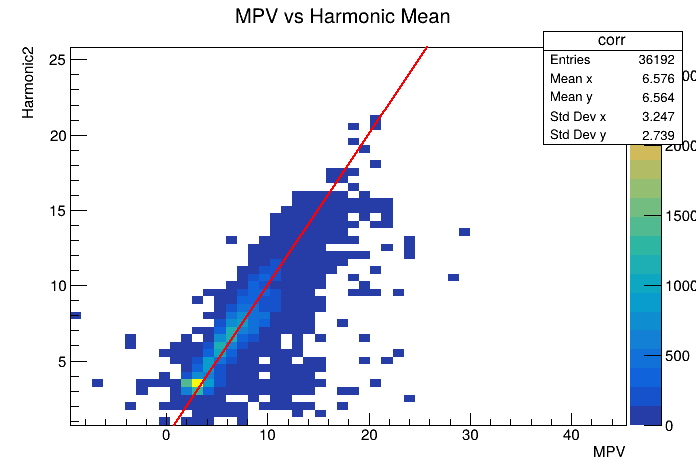

In [15]:




c = rt.TCanvas()

x_vals = [r[0] for r in corel_params]
y_vals = [r[1] for r in corel_params]
corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean;MPV;Harmonic2", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
for x, y in corel_params:
    corr_hist.Fill(x, y)
corr_hist.Draw("COLZ")


xmin, xmax = min(x_vals), max(x_vals)
ymin, ymax = min(y_vals), max(y_vals)


low  = max(xmin, ymin)
high = min(xmax, ymax)

diag = rt.TLine(low, low, high, high)   # y = x
diag.SetLineColor(rt.kRed)
diag.SetLineWidth(2)
diag.Draw("same")

c.Draw()

In [ ]:
#generate a number of landau fit with known mpvs, use the datasets that make up the landau fits to calculate the harmonic2. check the corelation of the two 
#understand why we still get negative values
# and what makes up the outliers

In [34]:
#TIGHTENED THE FIT RANGE AND INTRODUCED SEEDING

thrshld = 5
max_hists = 20000
hist_count = 0
# leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} #dictionary to store histograms
harmonic2_means = []
for event, tracks in zip(tree, cluster):
#  hists = []
    for trk_idx, track in enumerate(tracks): 
      if len(track) > thrshld:
        if hist_count >= max_hists:
          break
        #computing harmonic2
        harmonic2 = math.sqrt( len(track) / sum( (1.0 / (x*x)) for x in track if x > 0 ) )  #turn this into a function later on
        
        harmonic2_means.append(harmonic2)
        
        nbins, lo, hi = utils.freedman_diaconis_bins(track, range_pad = 0.05)
        
        hist_name = f"fit{hist_count}"
        title     = f"Ev {event.event}, Trk {trk_idx};dE/dx (MeV/cm);Entries"
        hist = rt.TH1F(hist_name, title, nbins, 0, hi)
        
        bin_width = str(round(hist.GetBinWidth(nbins), 2))
        
        hist.GetYaxis().SetTitle("Entries/"+ bin_width)
        
        # hist = rt.TH1F(hist_name, title, bin, 0, len(track))
        # bin_width = hist.GetBinWidth()
        #c = rt.TCanvas()
        # print(len(track))
      
        for hit in track:
            hist.Fill(hit)
        hist.Draw("P")
        hist.SetMarkerStyle(20)
        
        #trying to derive sensible seeds from each histogram
        amp_guess  = hist.GetMaximum()                       # scale
        mpv_guess  = hist.GetBinCenter(hist.GetMaximumBin()) # MPV
        sigma_guess = 0.3 * hist.GetRMS() or 0.1*mpv_guess   # crude width
        
        
        # xmin, xmax = fit_range(track, 1)
        f_landau = rt.TF1("f_landau", "landau", 0, hi)
        f_landau.SetParameters(amp_guess, mpv_guess, sigma_guess)   # seeds
        
        # I'm trying to keep Minuit away from crazy regions
        f_landau.SetParLimits(1, lo, hi)         # MPV must stay inside data
        f_landau.SetParLimits(2, 0.05, lo - hi)  # σ positive, < full range
        
        hist.Fit(f_landau, "RQ")
        #c.Draw("same")
        #print(track)
        
        hists[hist_name] = hist # stores histograms in dict with unique key
        
        hist_count += 1
        
    if hist_count >= max_hists:
        break  
  
print("Stored histograms:", list(hists.keys()), list(hists.values()))
print(harmonic2_means)

Stored histograms: ['fit0', 'fit1', 'fit2', 'fit3', 'fit4', 'fit5', 'fit6', 'fit7', 'fit8', 'fit9', 'fit10', 'fit11', 'fit12', 'fit13', 'fit14', 'fit15', 'fit16', 'fit17', 'fit18', 'fit19', 'fit20', 'fit21', 'fit22', 'fit23', 'fit24', 'fit25', 'fit26', 'fit27', 'fit28', 'fit29', 'fit30', 'fit31', 'fit32', 'fit33', 'fit34', 'fit35', 'fit36', 'fit37', 'fit38', 'fit39', 'fit40', 'fit41', 'fit42', 'fit43', 'fit44', 'fit45', 'fit46', 'fit47', 'fit48', 'fit49', 'fit50', 'fit51', 'fit52', 'fit53', 'fit54', 'fit55', 'fit56', 'fit57', 'fit58', 'fit59', 'fit60', 'fit61', 'fit62', 'fit63', 'fit64', 'fit65', 'fit66', 'fit67', 'fit68', 'fit69', 'fit70', 'fit71', 'fit72', 'fit73', 'fit74', 'fit75', 'fit76', 'fit77', 'fit78', 'fit79', 'fit80', 'fit81', 'fit82', 'fit83', 'fit84', 'fit85', 'fit86', 'fit87', 'fit88', 'fit89', 'fit90', 'fit91', 'fit92', 'fit93', 'fit94', 'fit95', 'fit96', 'fit97', 'fit98', 'fit99', 'fit100', 'fit101', 'fit102', 'fit103', 'fit104', 'fit105', 'fit106', 'fit107', 'fit108', 

Warning in <TFile::Append>: Replacing existing TH1: fit0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit6 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit7 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit8 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit9 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit10 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit11 (Potential memory leak).
Warning in <TF

In [35]:
c = rt.TCanvas()
stack = utils.write_stacked_histos("fits", hists, "some tracks fitted with the landau", c)

Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


In [36]:
fit_list = stack.GetHists()

In [37]:
# #just drawing the graphs
# N = fit_list.GetSize()

# cols = 2
# rows = math.ceil(N/cols)

# c = rt.TCanvas("c_all", "All fits", cols*800, rows*800)
# c.Divide(cols, rows)

# for i in range(N):
#   pad = c.cd(i+1)
#   fit = fit_list.At(i)
#   fit.Draw()

# c.Modified()
# c.Draw()

In [38]:
# drawer.save(c, f"{utils.PLOTS_DIR}/some ratio plots seeded, with freedman_diaconis bin width",["png"])

In [44]:
print(len(fit_list))
print(type(fit_list[0]))

9048
<class cppyy.gbl.TH1F at 0x5c3dd9b6f570>


In [45]:
params = fit_result.GetParameter(1)
print(params)

6.286433656977105


In [46]:
corel_params = []      # (mpv, h2_mean)
parameters   = []      # (mpv, sigma)
count = 0

for (hist_name, hist), h2_mean in zip(hists.items(), harmonic2_means):
    f = hist.GetFunction("f_landau")
    if not f:                          # fit might have failed
        print(f"[skip] {hist_name}: no Landau function attached")
        continue
    npar = f.GetNpar()
    params = [f.GetParameter(i) for i in range(npar)]
    errors = [f.GetParError(i)  for i in range(npar)]
    print(f"fit {count}")
    count += 1
    for i, (val, err) in enumerate(zip(params, errors)):
        msg = f" vs {h2_mean}" if i == 1 else ""
        print(f"par[{i}] = {val:.4g} ± {err:.4g} {msg}")
        corel_params.append((params[1],h2_mean))
        
    print("\n")
    
    corel_params.append((params[1], h2_mean))
    parameters.append((params[1], params[2]))

# print(" (mpv, sigma):", parameters)
# print(" (mpv, h2) :", corel_params)


fit 0
par[0] = 447.9 ± 5123 
par[1] = 6.286 ± 3.537  vs 7.421176829131537
par[2] = 0.2016 ± 1.233 


fit 1
par[0] = 66.44 ± 154.1 
par[1] = 7.937 ± 2.72  vs 7.9114921980772355
par[2] = 0.2478 ± 2.322 


fit 2
par[0] = 50.13 ± 103.1 
par[1] = 7.579 ± 3.227  vs 8.018106647450566
par[2] = 1.813 ± 8.831 


fit 3
par[0] = 33.22 ± 125.7 
par[1] = 19 ± 6.719  vs 20.58474498736195
par[2] = 0.2489 ± 2.357 


fit 4
par[0] = 29.87 ± 132 
par[1] = 3.677 ± 3.146  vs 4.015593641546164
par[2] = 0.9537 ± 2.527 


fit 5
par[0] = 66.46 ± 132.2 
par[1] = 5.8 ± 2.137  vs 6.197852518116716
par[2] = 0.2469 ± 2.314 


fit 6
par[0] = 131.1 ± 329.4 
par[1] = 2.976 ± 0.2666  vs 3.348420720306829
par[2] = 0.147 ± 0.187 


fit 7
par[0] = 44.57 ± 72.44 
par[1] = 7.02 ± 2.592  vs 5.77779538090345
par[2] = 2.048 ± 7.374 


fit 8
par[0] = 47.46 ± 21.64 
par[1] = 3.075 ± 0.2855  vs 3.3393716918414365
par[2] = 0.4164 ± 0.1927 


fit 9
par[0] = 60.96 ± 90.72 
par[1] = 7.746 ± 2.633  vs 8.607759714305358
par[2] = 0.2458 

In [47]:
# c = rt.TCanvas()

# N = len(corel_params)
# hist_mpv = rt.


# for i in range(N):
#   hist.Fill(hit)
#   hist.Draw("P")

Warning in <TFile::Append>: Replacing existing TH1: corr (Potential memory leak).


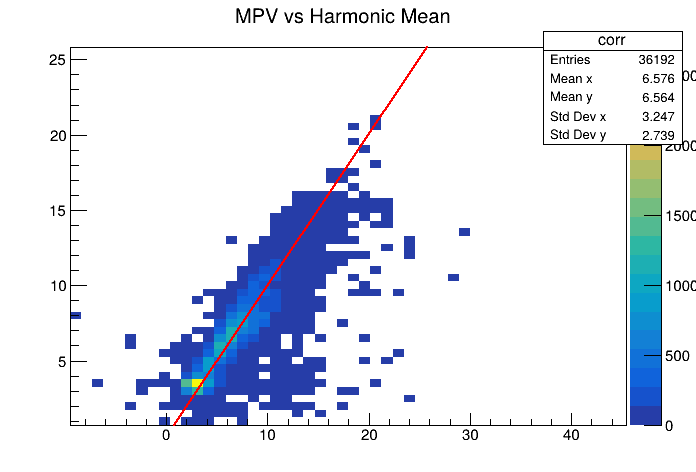

In [48]:
c = rt.TCanvas()

x_vals = [r[0] for r in corel_params]
y_vals = [r[1] for r in corel_params]
corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
for x, y in corel_params:
    corr_hist.Fill(x, y)
corr_hist.Draw("COLZ")


xmin, xmax = min(x_vals), max(x_vals)
ymin, ymax = min(y_vals), max(y_vals)


low  = max(xmin, ymin)
high = min(xmax, ymax)

diag = rt.TLine(low, low, high, high)   # y = x
diag.SetLineColor(rt.kRed)
diag.SetLineWidth(2)
diag.Draw("same")

c.Draw()

In [ ]:
# import ROOT as rt
# import math, numpy as np

# thrshld    = 10          # min strip hits per track
# max_hists  = 5000        # safety cap (optional)

# mpv_h2_pairs = []        # final flat list of (MPV, harmonic-2)

# hist_count   = 0
# hists_good   = {}        # keep only successfully-fitted histos

# for event, tracks in zip(tree, cluster):               # cluster parallels tree
#     for trk_idx, track in enumerate(tracks):

#         if len(track) <= thrshld:
#             continue

#         # ---------- build & fill histogram
#         hist_name = f"trkFit{hist_count}"
#         hist      = rt.TH1F(hist_name, "dE/dx per strip", len(track), 0, len(track))
#         for hit in track:
#             hist.Fill(hit)

#         if hist.GetEntries() < 6:          # too little data ⇒ skip
#             continue

#         # ---------- Landau fit
#         fit_ptr = hist.Fit("landau", "QS0")      # Q=quiet, S=return result, 0=no-draw
#         if not fit_ptr or fit_ptr.Status() != 0: # fit did not converge → skip
#             hist_count += 1
#             continue

#         # ---------- extract MPV from the fit
#         landau_f = hist.GetFunction("landau")
#         mpv      = landau_f.GetParameter(1)      # Most-probable value

#         # ---------- compute harmonic-2 ( Ih )
#         h2 = math.sqrt(len(track) /
#                        sum((1.0 / (x*x)) for x in track if x > 0))

#         # ---------- store results
#         mpv_h2_pairs.append((mpv, h2))
#         hists_good[hist_name] = hist
#         hist_count += 1

#         if hist_count >= max_hists:
#             break
#     if hist_count >= max_hists:
#         break

# # ------------- flat NumPy array if you like
# mpv_h2_np = np.array(mpv_h2_pairs, dtype=np.float64)   # shape (N, 2)

# print(f"Kept {len(mpv_h2_pairs)} fitted tracks out of {hist_count} candidates")
# print("First five (MPV, harmonic-2) pairs:\n", mpv_h2_pairs[:5])
